In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import skew, kurtosis, shapiro

In [ ]:
df = pd.read_csv('Ventas.csv', parse_dates=['Fecha'], dayfirst=False, index_col='Fecha')

df.index = pd.to_datetime(df.index, format='%Y-%m-%d', errors='coerce')

# Now you can access the parsed dates
print(df.head())

            Gas licuado de petróleo  Gasolina regular  Gasolina superior  \
Fecha                                                                      
2000-01-01            194410.476190         202645.20          308156.82   
2000-02-01            174710.552381         205530.96          307766.31   
2000-03-01            189234.066667         229499.56          331910.29   
2000-04-01            174330.607143         210680.40          315648.08   
2000-05-01            191745.147619         208164.34          319667.97   

               Diesel  
Fecha                  
2000-01-01  634667.06  
2000-02-01  642380.66  
2000-03-01  699807.25  
2000-04-01  586803.98  
2000-05-01  656948.20  


# Analisis exploratorio #

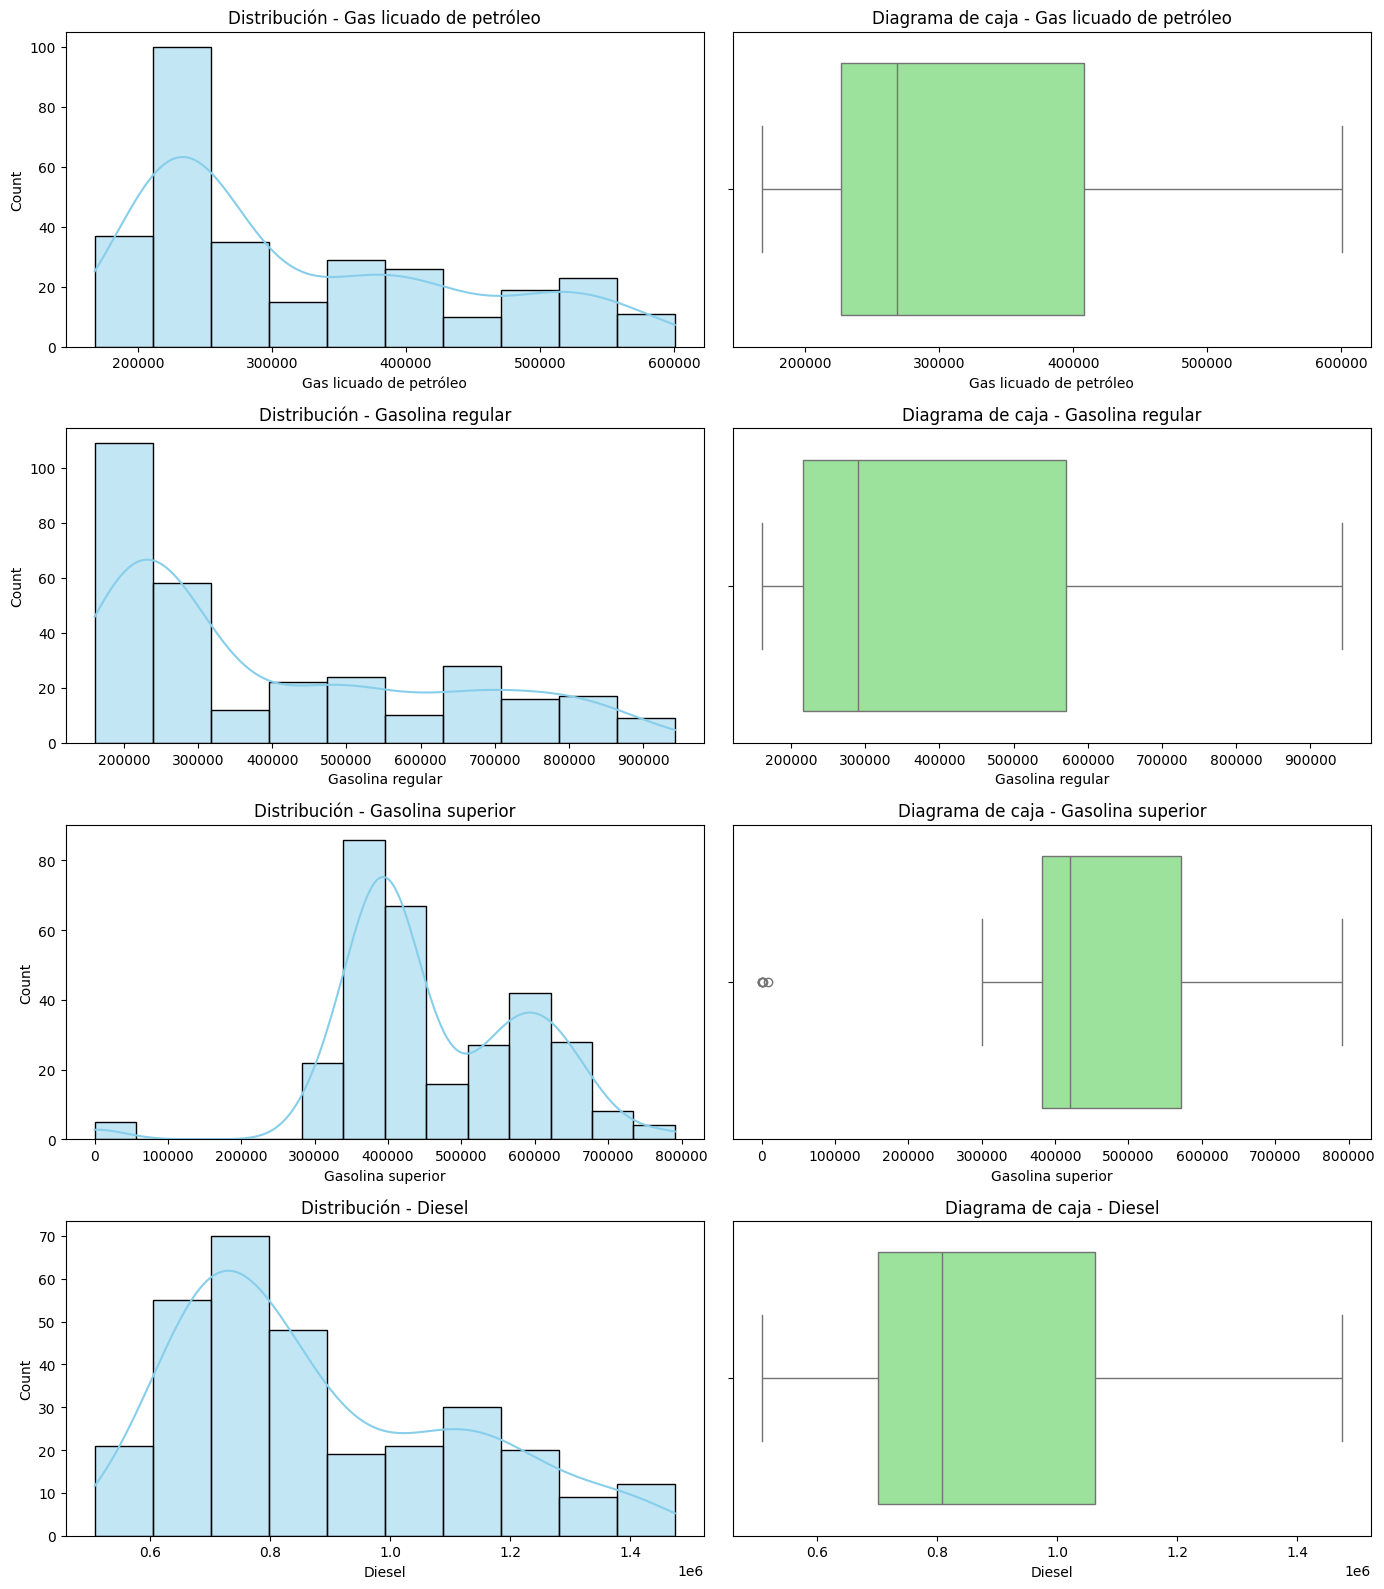

In [113]:
columnas = ['Gas licuado de petróleo', 'Gasolina regular', 'Gasolina superior', 'Diesel']
datos = df[columnas]

# Crear un diccionario para almacenar resultados
resultados = {}

# Análisis estadístico para cada variable
for col in columnas:
    valores = datos[col].dropna()
    media = np.mean(valores)
    mediana = np.median(valores)
    std = np.std(valores)
    asimetria = skew(valores)
    curtosis_val = kurtosis(valores)
    stat, p = shapiro(valores)
    
    resultados[col] = {
        'Media': media,
        'Mediana': mediana,
        'Desviación estándar': std,
        'Asimetría': asimetria,
        'Curtosis': curtosis_val,
        'Shapiro-Wilk p-valor': p
    }

# Mostrar las estadísticas
estadisticas = pd.DataFrame(resultados).T

# Graficar distribuciones y boxplots
fig, axs = plt.subplots(4, 2, figsize=(14, 16))

for i, col in enumerate(columnas):
    sns.histplot(datos[col], kde=True, ax=axs[i, 0], color='skyblue')
    axs[i, 0].set_title(f'Distribución - {col}')
    
    sns.boxplot(x=datos[col], ax=axs[i, 1], color='lightgreen')
    axs[i, 1].set_title(f'Diagrama de caja - {col}')

plt.tight_layout()
plt.show()

In [114]:
estadisticas

,Media,Mediana,Desviación estándar,Asimetría,Curtosis,Shapiro-Wilk p-valor
Gas licuado de petróleo,322885.822617,268875.095238,118786.556387,0.762418,-0.714944,1.281581e-14
Gasolina regular,402879.505696,290286.650000,221023.988459,0.786103,-0.794288,1.325852e-16
Gasolina superior,462617.407294,420370.600000,127220.585050,-0.205343,1.322405,6.977121e-12
Diesel,880197.590733,807692.100000,231602.374826,0.723846,-0.483713,3.763013e-11


Al ser todos los valores p menores que 0.05 se rechaza la hipotesis nula por lo que ninguna de las variables tiene normalidad.

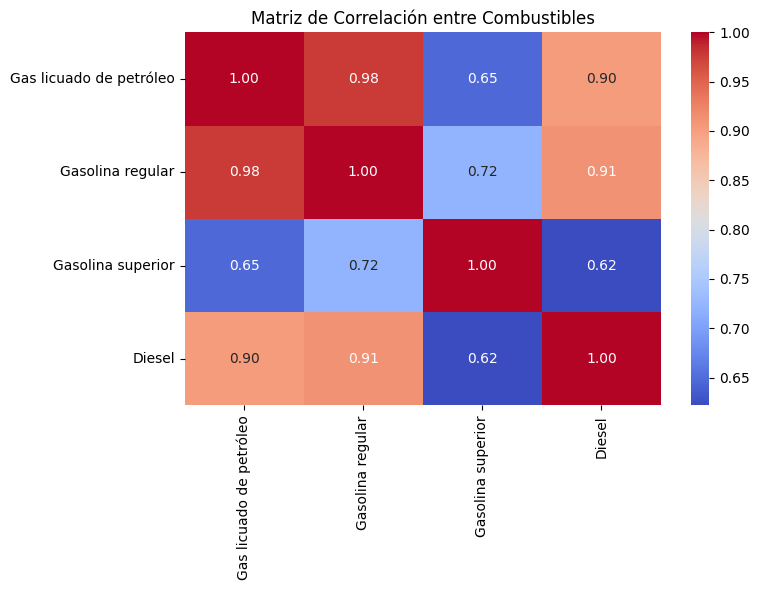

,Gas licuado de petróleo,Gasolina regular,Gasolina superior,Diesel
Gas licuado de petróleo,1.000000,0.977199,0.645525,0.903024
Gasolina regular,0.977199,1.000000,0.721148,0.911885
Gasolina superior,0.645525,0.721148,1.000000,0.621881
Diesel,0.903024,0.911885,0.621881,1.000000


In [115]:
plt.figure(figsize=(8, 6))
correlacion = datos.corr()
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación entre Combustibles")
plt.tight_layout()
plt.show()

correlacion

Parece haber un fuerte grade de correlacion entre las variables Gas Licuado, Gasolina Regular y Diesel dado que se describen entre si con un 90% de precision por otro lado la variable Gasolina Superior no esta tan fuertemente relacionado con estas aunque si guarda cierto nivel de correlacion.

# Series de tiempo #

In [116]:
train_size = int(len(df) * 0.7)
train_df = df[0:train_size]
test_df = df[train_size:len(df)]

In [117]:
Gasl_df = train_df['Gas licuado de petróleo']
Gasl_df.head(10)

Gasl_df

Fecha
2000-01-01    194410.476190
2000-02-01    174710.552381
2000-03-01    189234.066667
2000-04-01    174330.607143
2000-05-01    191745.147619
                  ...      
2017-05-01    377542.430000
2017-06-01    378389.980000
2017-07-01    369996.240000
2017-08-01    385885.050000
2017-09-01    378419.910000
Name: Gas licuado de petróleo, Length: 213, dtype: float64

In [118]:
Gasr_df = train_df['Gasolina regular']
Gasr_df.head(10)

Fecha
2000-01-01    202645.20
2000-02-01    205530.96
2000-03-01    229499.56
2000-04-01    210680.40
2000-05-01    208164.34
2000-06-01    195088.74
2000-07-01    204556.77
2000-08-01    218388.51
2000-09-01    213906.96
2000-10-01    213606.65
Name: Gasolina regular, dtype: float64

In [119]:
Gass_df = train_df['Gasolina superior']
Gass_df.head(10)

Fecha
2000-01-01    308156.82
2000-02-01    307766.31
2000-03-01    331910.29
2000-04-01    315648.08
2000-05-01    319667.97
2000-06-01    300347.70
2000-07-01    308305.93
2000-08-01    323011.86
2000-09-01    326455.72
2000-10-01    323843.63
Name: Gasolina superior, dtype: float64

In [120]:
Gasd_df = train_df['Diesel']
Gasd_df.head(10)

Fecha
2000-01-01    634667.06
2000-02-01    642380.66
2000-03-01    699807.25
2000-04-01    586803.98
2000-05-01    656948.20
2000-06-01    570919.88
2000-07-01    576436.02
2000-08-01    593770.77
2000-09-01    590145.40
2000-10-01    641113.36
Name: Diesel, dtype: float64

# ARIMA Gas licuado #

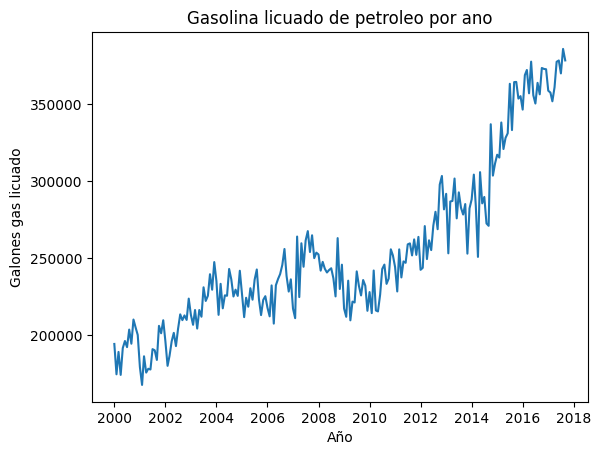

In [121]:
plt.plot(Gasl_df)
plt.gca().set(title="Gasolina licuado de petroleo por ano", xlabel="Año", ylabel="Galones gas licuado")
plt.show()

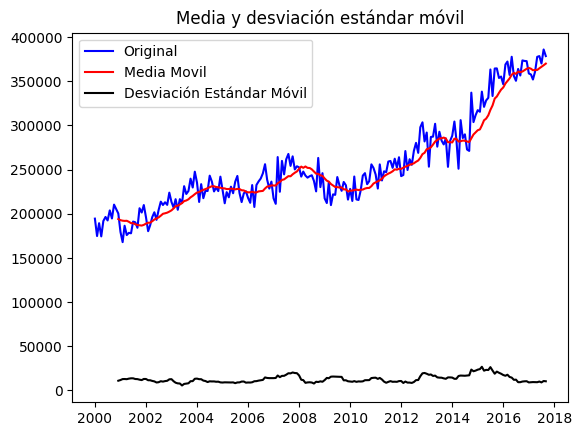

In [122]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = Gasl_df.rolling(window=12).mean()
deMovil = Gasl_df.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(Gasl_df, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

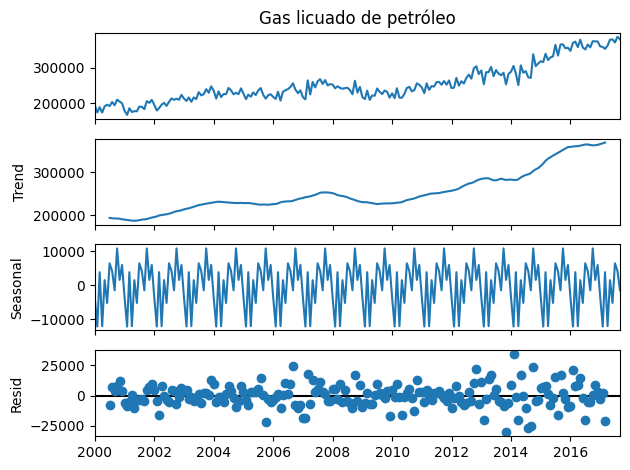

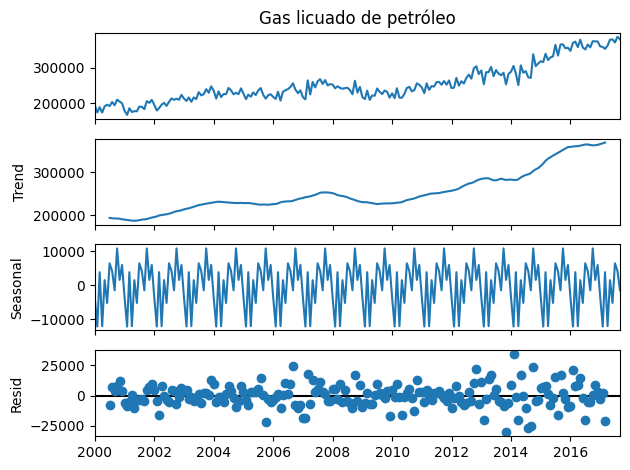

In [123]:
descomposicion = seasonal_decompose(Gasl_df)
descomposicion.plot()

Existe tendencia por lo que no parece ser estacionaria en la media ni en la varianza.

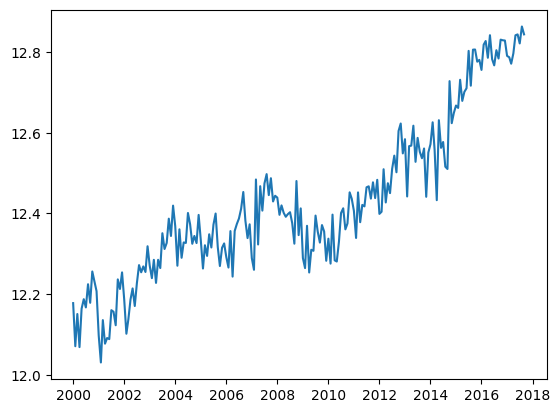

In [136]:
Gasl_df_log = np.log(Gasl_df)
plt.plot(Gasl_df_log)

# ARIMA Gasolina Regular #

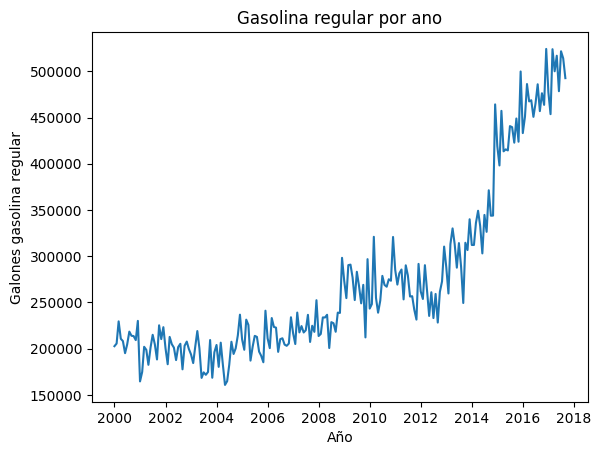

In [124]:
plt.plot(Gasr_df)
plt.gca().set(title="Gasolina regular por ano", xlabel="Año", ylabel="Galones gasolina regular")
plt.show()

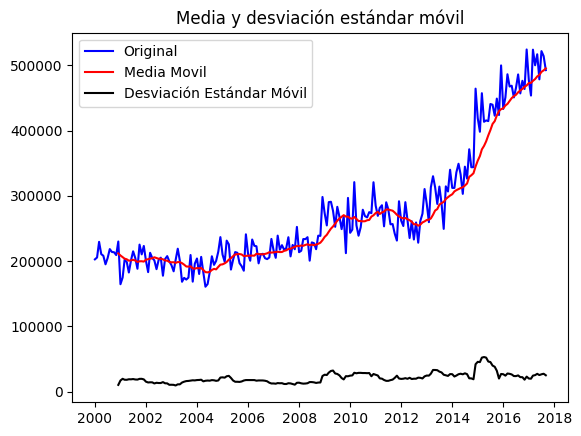

In [125]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = Gasr_df.rolling(window=12).mean()
deMovil = Gasr_df.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(Gasr_df, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

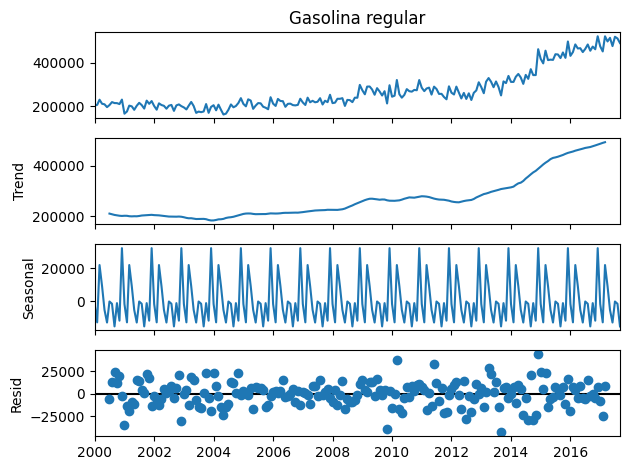

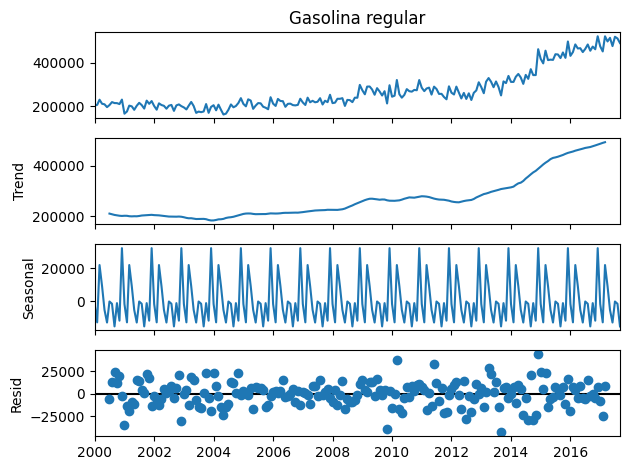

In [126]:
descomposicion = seasonal_decompose(Gasr_df)
descomposicion.plot()

Existe tendencia por lo que no parece ser estacionaria en la media ni en la varianza.

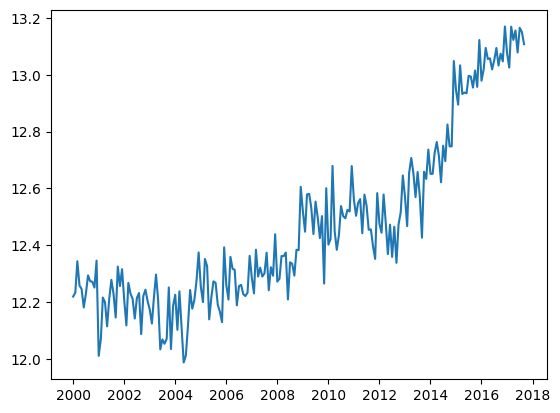

In [135]:
Gasr_df_log = np.log(Gasr_df)
plt.plot(Gasr_df_log)

# ARIMA Gasolina super #

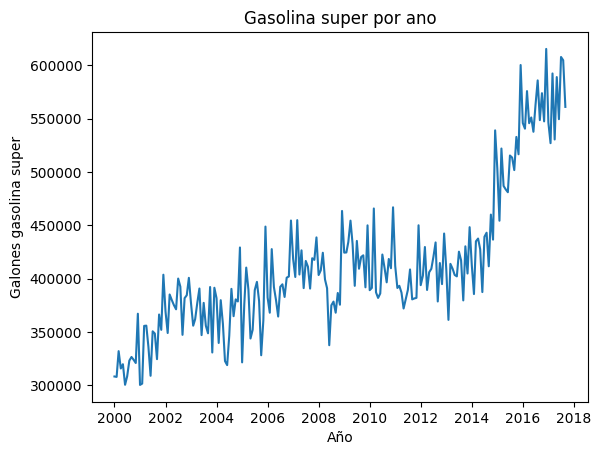

In [127]:
plt.plot(Gass_df)
plt.gca().set(title="Gasolina super por ano", xlabel="Año", ylabel="Galones gasolina super")
plt.show()

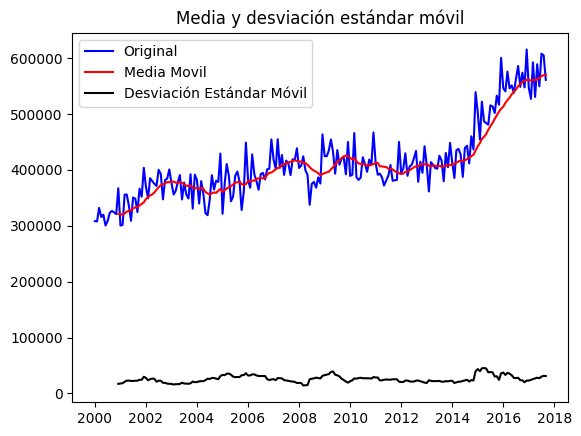

In [128]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = Gass_df.rolling(window=12).mean()
deMovil = Gass_df.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(Gass_df, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

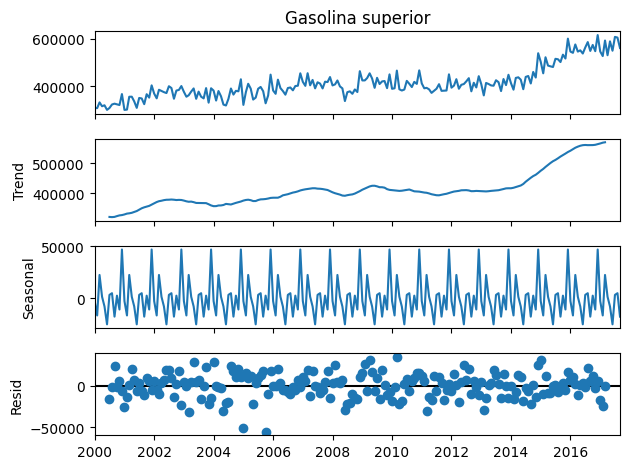

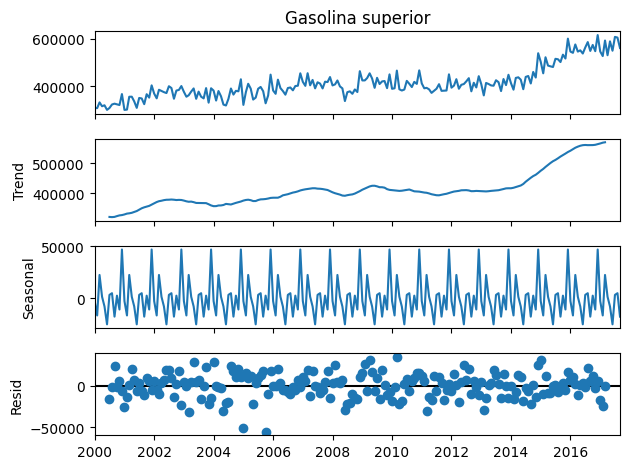

In [129]:
descomposicion = seasonal_decompose(Gass_df)
descomposicion.plot()

Existe tendencia por lo que no parece ser estacionaria en la media ni en la varianza.

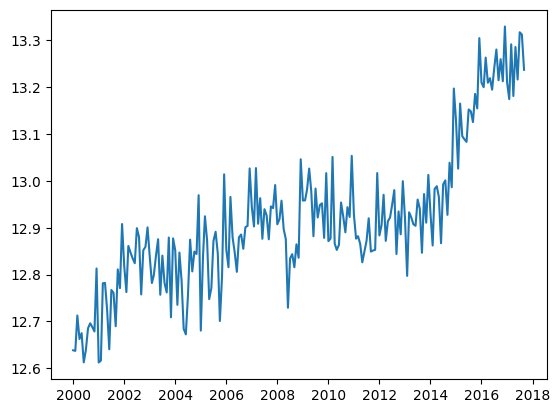

In [134]:
Gass_df_log = np.log(Gass_df)
plt.plot(Gass_df_log)

# ARIMA Diesel #

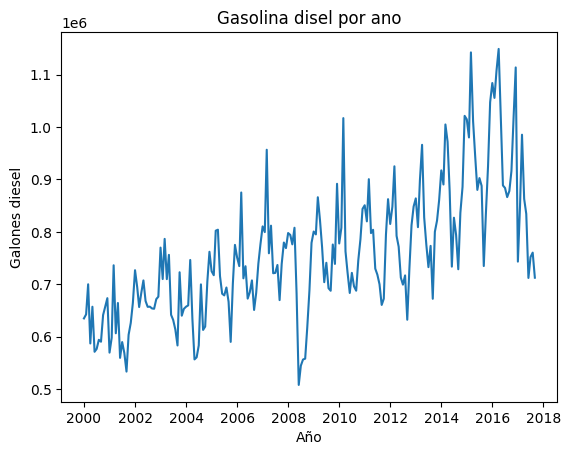

In [130]:
plt.plot(Gasd_df)
plt.gca().set(title="Gasolina disel por ano", xlabel="Año", ylabel="Galones diesel")
plt.show()

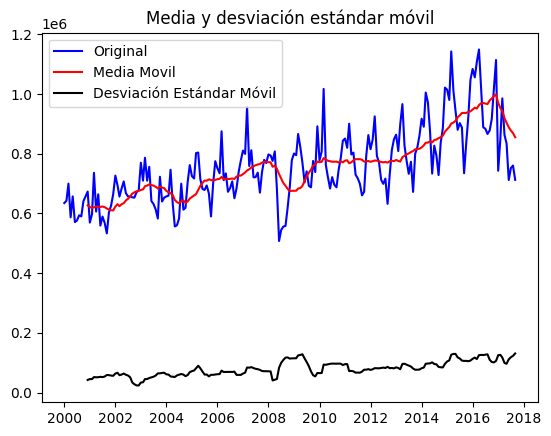

In [131]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = Gasd_df.rolling(window=12).mean()
deMovil = Gasd_df.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(Gasd_df, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

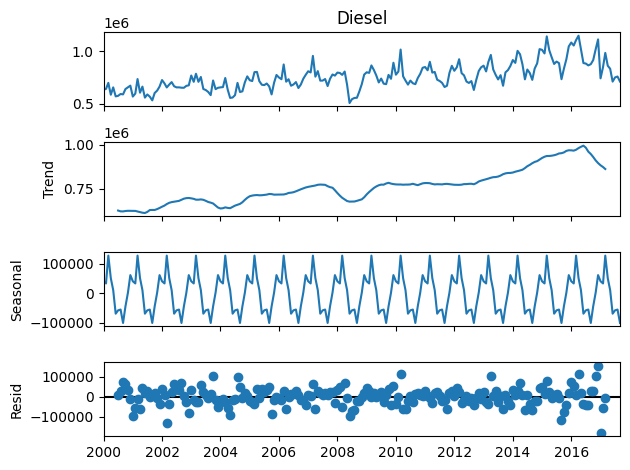

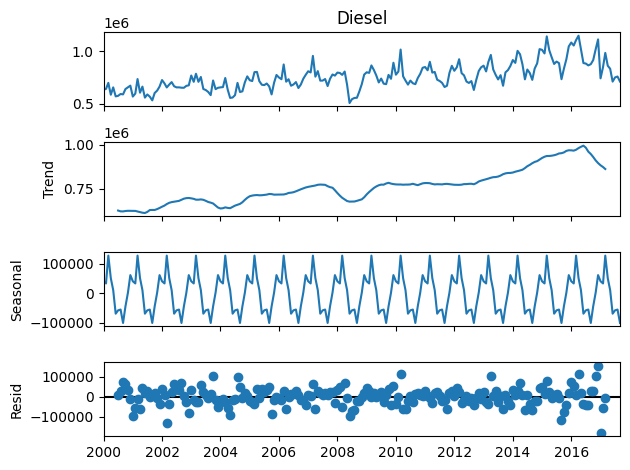

In [132]:
descomposicion = seasonal_decompose(Gasd_df)
descomposicion.plot()

Existe tendencia por lo que no parece ser estacionaria en la media ni en la varianza.

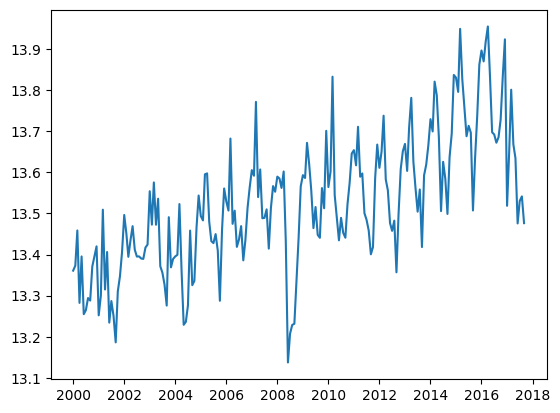

In [133]:
Gasd_df_log = np.log(Gasd_df)
plt.plot(Gasd_df_log)